In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
dt = pd.read_csv("kaggle\\icr\\train.csv")
greek = pd.read_csv("kaggle\\icr\\greeks.csv")

In [3]:
one_hot_greek = pd.get_dummies(greek[[c for c in greek.columns if c!="Id" and c!="Epsilon"]])

In [4]:
one_hot_greek["Id"]=greek["Id"]

In [5]:
greek

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


In [6]:
one_hot_greek

,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D,Id
0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,000ff2bfdfe9
1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,007255e47698
2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,013f2bd269f5
3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,043ac50845d5
4,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,044fb8a146ec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,fd3dafe738fd
613,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,fd895603f071
614,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,fd8ef6377f76
615,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,fe1942975e40


In [7]:
targs = [one_hot_greek[c] for c in one_hot_greek.columns[1:4]]

In [8]:
one_hot_greek[one_hot_greek.columns[4:18]]

,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,0,0,1,0,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,0,0,1,0,0,1,0
4,0,1,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0,1,0,0,0,0,0,0,0,1,0,0,1,0
613,0,1,0,0,0,0,0,0,0,1,0,0,1,0
614,0,0,1,0,0,0,0,0,0,1,0,0,1,0
615,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [9]:
dt = dt.fillna(0.0001)
dt["EJ"] = dt["EJ"].map({"B":1,"A":0})

In [10]:
dt.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [11]:
xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.005, 
        'max_depth': 4,
        'colsample_bytree': 0.50,
        'subsample': 0.80,
        'eta': 0.03,
        'gamma': 1.5}

In [12]:
combine = dt.merge(one_hot_greek,left_on="Id",right_on="Id",how="left")

In [13]:
combine = combine.drop(columns=["Id"])

In [14]:
combine.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,0,0,1,0,0,0,0,0,0,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0,0,0,0,1,0,0,1,0,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0,0,0,0,1,0,0,1,0,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0,0,0,0,1,0,0,1,0,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,0,1,0,0,0,0,0,1,0,0


In [15]:
combine.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,0.012966,0.016207,0.012966,0.085900,0.721232,0.103728,0.121556,0.739060,0.103728,0.035656
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,0.113219,0.126375,0.113219,0.280443,0.448757,0.305154,0.327037,0.439504,0.305154,0.185582
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
print(combine.columns)

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Alpha_A',
       'Alpha_B', 'Alpha_D', 'Alpha_G', 'Beta_A', 'Beta_B', 'Beta_C',
       'Gamma_A', 'Gamma_B', 'Gamma_E', 'Gamma_F', 'Gamma_G', 'Gamma_H',
       'Gamma_M', 'Gamma_N', 'Delta_A', 'Delta_B', 'Delta_C', 'Delta_D'],
      dtype='object')


In [17]:
extra_features = [c for c in combine.columns if len(c)>3]

In [18]:
print(extra_features)
print(len(extra_features))

['Class', 'Alpha_A', 'Alpha_B', 'Alpha_D', 'Alpha_G', 'Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E', 'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'Delta_A', 'Delta_B', 'Delta_C', 'Delta_D']
20


In [19]:
org_features = [c for c in combine.columns if len(c)<4]

In [20]:
print(org_features)
print(len(org_features))

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
56


In [21]:
T_extra_features = extra_features[5:]

In [22]:
Alphas = extra_features[1:5]

In [23]:
Alphas

['Alpha_A', 'Alpha_B', 'Alpha_D', 'Alpha_G']

In [24]:
Alphas_ot = Alphas[1:]

In [25]:
num_round = 200
params1={'max_depth':5, 'objective':'binary:logistic'}

In [26]:
test_index,train_index = train_test_split(np.array([i for i in range(617)]),train_size=0.2,random_state=5)

In [27]:
combine[Alphas_ot[0]][test_index]

171    0
577    0
578    0
35     0
453    0
      ..
8      0
73     0
400    0
118    1
206    0
Name: Alpha_B, Length: 123, dtype: uint8

In [28]:
train_x = combine[org_features].iloc[train_index]

In [29]:
train_y1 = combine[Alphas_ot[0]][train_index]

In [30]:
train_y1.shape

(494,)

In [31]:
train_x.shape

(494, 56)

In [32]:
matrix = xgb.DMatrix(train_x,train_y1)

In [33]:
xgb.train?

In [34]:
md1 = xgb.train(params = params1,dtrain=matrix,num_boost_round=200)

In [35]:
test_matrix = xgb.DMatrix(combine[org_features].iloc[test_index])

In [36]:
y_pred_1 = np.array([int(n>0.5) for n in md1.predict(test_matrix)])

In [37]:
y_true_1 = combine[Alphas_ot[0]][test_index]

In [38]:
confusion_matrix(np.array(y_true_1),y_pred_1)

array([[108,   1],
       [  5,   9]], dtype=int64)

In [39]:
train_y2 = combine[Alphas_ot[1]][train_index]
matrix2 = xgb.DMatrix(train_x,train_y2)
md2 = xgb.train(params = params1,dtrain=matrix2,num_boost_round=200)

In [40]:
y_pred_2 = np.array([int(n>0.5) for n in md2.predict(test_matrix)])
y_true_2 = combine[Alphas_ot[1]][test_index]

In [41]:
combine[Alphas_ot[1]].value_counts()

0    599
1     18
Name: Alpha_D, dtype: int64

In [42]:
combine[Alphas_ot[1]][test_index].value_counts()

0    120
1      3
Name: Alpha_D, dtype: int64

In [43]:
for i in range(len(Alphas_ot)):
    print(combine[Alphas_ot[i]].value_counts())
    print(combine[Alphas_ot[i]][test_index].value_counts())

0    556
1     61
Name: Alpha_B, dtype: int64
0    109
1     14
Name: Alpha_B, dtype: int64
0    599
1     18
Name: Alpha_D, dtype: int64
0    120
1      3
Name: Alpha_D, dtype: int64
0    588
1     29
Name: Alpha_G, dtype: int64
0    119
1      4
Name: Alpha_G, dtype: int64


In [44]:
confusion_matrix(np.array(y_true_2),y_pred_2)

array([[120,   0],
       [  1,   2]], dtype=int64)

In [45]:
train_y3 = combine[Alphas_ot[2]][train_index]
matrix3 = xgb.DMatrix(train_x,train_y3)
md3 = xgb.train(params = params1,dtrain=matrix3,num_boost_round=200)

In [46]:
y_pred_3 = np.array([int(n>0.015) for n in md3.predict(test_matrix)])
y_true_3 = combine[Alphas_ot[2]][test_index]

In [47]:
print(classification_report(np.array(y_true_3),y_pred_3))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       119
           1       0.31      1.00      0.47         4

    accuracy                           0.93       123
   macro avg       0.65      0.96      0.72       123
weighted avg       0.98      0.93      0.94       123



In [48]:
confusion_matrix(np.array(y_true_3),y_pred_3)

array([[110,   9],
       [  0,   4]], dtype=int64)

In [49]:
sum(y_pred_3)

13

In [50]:
combine["Class"].iloc[test_index].value_counts()

0    102
1     21
Name: Class, dtype: int64

In [51]:
md2.predict(test_matrix)

array([9.49780282e-04, 2.42901943e-03, 3.62602004e-04, 2.40734708e-03,
       1.82197650e-03, 2.57019186e-04, 1.28893915e-03, 7.72221363e-04,
       3.74272902e-04, 7.06666848e-04, 2.52661092e-04, 3.07531911e-04,
       1.04395729e-02, 5.39177854e-04, 2.17400506e-04, 4.97441739e-04,
       1.81259331e-03, 1.38246594e-02, 3.09108320e-04, 1.30375087e-01,
       6.31599454e-04, 1.13648828e-03, 1.25956460e-04, 4.59241797e-04,
       1.71841515e-04, 7.17435241e-01, 3.33277480e-04, 3.49390641e-04,
       4.73814347e-04, 8.02675277e-05, 2.35185539e-03, 5.04154246e-04,
       6.85581518e-03, 2.42999900e-04, 6.33510249e-03, 4.71334253e-03,
       1.14041567e-03, 3.07945302e-04, 1.19897490e-03, 9.14605379e-01,
       1.12812466e-03, 1.04383361e-02, 6.03039982e-04, 6.63047284e-03,
       9.90574947e-04, 2.26772710e-04, 1.56771820e-02, 6.46089029e-04,
       1.27225358e-04, 2.04152963e-03, 1.32504996e-04, 1.15664536e-03,
       3.01260268e-03, 2.13582869e-04, 1.53388828e-04, 5.26472414e-03,
      

In [52]:
pds = [md1.predict(test_matrix),md2.predict(test_matrix),md3.predict(test_matrix)]

In [53]:
alt_dt = pd.DataFrame(data=[[v for v in combine[org_features].iloc[i]]+[pds[0][i],pds[1][i],pds[2][i]] for i in range(len(test_index))])

In [54]:
alt_dt

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.587310,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,0.003453,0.000950,0.000181
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.928240,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0.000557,0.002429,0.001468
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.780240,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0.000085,0.000363,0.001182
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.677380,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0.000757,0.002407,0.000566
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.734120,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,0.000325,0.001822,0.000323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.653769,11786.13326,85.200147,168.541837,22.085106,6.316467,0.025578,11.186050,1.229900,5894.211015,...,0.067730,22.413169,90.029503,7835.870097,40.309593,100.806968,0.017348,0.000138,0.000510,0.000153
119,0.405935,1011.87218,91.122267,69.840447,8.138688,6.573378,0.025578,7.398548,1.229900,3204.013970,...,0.392834,14.725066,72.611063,13055.309620,31.795945,29.781188,0.141429,0.000317,0.000259,0.003873
120,0.235015,7233.17430,85.200147,5.562212,8.138688,4.695270,0.025578,7.360736,1.229900,3160.013040,...,0.067730,8.669464,151.516351,11307.586070,11.654172,29.017304,0.379500,0.000510,0.000635,0.001075
121,1.140891,1649.24331,170.365458,59.549116,10.545684,8.717256,0.151032,10.272260,8.352778,8128.658460,...,0.568932,20.696950,72.611063,14796.295030,44.116176,33.716348,0.079595,0.920818,0.011908,0.007442


In [55]:
y_class_pred = [int(pds[0][i]+pds[1][i]+pds[2][i]>0.5) for i in range(len(test_index))]

In [56]:
last_train_matrix = combine[org_features+Alphas_ot].iloc[train_index]
y_train = combine["Class"].iloc[train_index]

In [57]:
last_true_train_matrix = xgb.DMatrix(last_train_matrix,y_train)

In [58]:
params2 = {'max_depth': 6, 'objective': 'binary:logistic'}

In [59]:
def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

In [60]:
def pred_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

此处下方的params使用了他人的notebook提供的

In [61]:
last_model = xgb.train(params=xgb_params,dtrain=last_true_train_matrix,num_boost_round=10,custom_metric=pred_metric)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

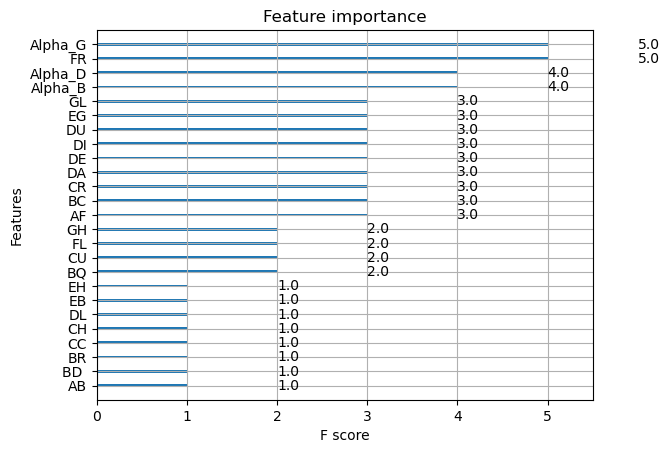

In [62]:
xgb.plot_importance(last_model)

In [63]:
alt_dt.columns = org_features+['Alpha_B', 'Alpha_D', 'Alpha_G']

In [64]:
last_matrix = xgb.DMatrix(alt_dt)

In [65]:
last_pred = last_model.predict(last_matrix)

In [66]:
confusion_matrix(combine["Class"][test_index],y_class_pred)

array([[101,   1],
       [  7,  14]], dtype=int64)

In [67]:
print(classification_report(combine["Class"][test_index],y_class_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       102
           1       0.93      0.67      0.78        21

    accuracy                           0.93       123
   macro avg       0.93      0.83      0.87       123
weighted avg       0.93      0.93      0.93       123



In [68]:
accuracy_score(combine["Class"][test_index],y_class_pred)

0.9349593495934959

In [69]:
dt.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [70]:
def plot_distribution(data):
    num_cols = 4
    num_rows = 1+len(data.columns) // num_cols
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(80,80))
    sns.set(font_scale=1.2, style='whitegrid')
    target_col = data["Class"]
    i = 0
    for col_name in (data.columns):
        if col_name != 'Class' and col_name!="Id":
            axi = axes[i // num_cols, i % num_cols]
            sns.kdeplot(dt[col_name],ax = axi, hue=dt["Class"],fill=True, alpha=0.5, linewidth=2)
            # sns.kdeplot(data=original, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)

            axi.set_title(f'{col_name} Distribution by {"Class"}', fontsize=14)
            axi.set_xlabel(col_name, fontsize=14)
            axi.set_ylabel("Density", fontsize=14)
            axi.tick_params(axis='both', which='major', labelsize=12)
            axi.legend([1, 0], title="Class", fontsize=12)
            i+=1

    plt.tight_layout()
    plt.show()
    
plot_distribution(dt)

for i in range(len(org_features)):
    for j in range(len(org_features)):
        if i!=j:
            tester = xgb.XGBClassifier()
            tester.fit()

xgbc = xgb.XGBRFClassifier()

targdts = (combine["Alpha_A"])

targdts[:20]

trainX = traindt[[c for c in traindt.columns if c!="Class"]]
trainy = traindt["Class"]

trainX["EJ"]

xgbc.fit(trainX,trainy)

valX = valdt[[c for c in traindt.columns if c!="Class"]]
valy = valdt["Class"]

xgbc.score(valX,valy)

sns.heatmap(dt.corr())

dt.corr()["Class"]["AB"]

In [71]:
greek[greek.columns[2:]]

,Beta,Gamma,Delta,Epsilon
0,C,G,D,3/19/2019
1,C,M,B,Unknown
2,C,M,B,Unknown
3,C,M,B,Unknown
4,B,F,B,3/25/2020
...,...,...,...,...
612,B,M,B,9/13/2020
613,B,M,B,9/8/2020
614,C,M,B,7/24/2019
615,C,M,B,1/31/2019


In [72]:
mapped_greek = greek.copy()

In [73]:
for c in greek.columns[2:]:
    d = {}
    for i in greek.index:
        w = greek[c][i]
        if w not in d:
            d[w]=len(d)+1
    mapped_greek[c] = mapped_greek[c].map(d)

In [74]:
mapped_greek

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,1,1,1,1
1,007255e47698,A,1,2,2,2
2,013f2bd269f5,A,1,2,2,2
3,043ac50845d5,A,1,2,2,2
4,044fb8a146ec,D,2,3,2,3
...,...,...,...,...,...,...
612,fd3dafe738fd,A,2,2,2,37
613,fd895603f071,A,2,2,2,84
614,fd8ef6377f76,A,1,2,2,198
615,fe1942975e40,A,1,2,2,32


In [75]:
mapped_greek["Beta"].value_counts()

1    407
2    202
3      8
Name: Beta, dtype: int64

In [76]:
mapped_greek["Gamma"].value_counts()

2    445
4     64
6     53
8     18
7     11
3     10
1      8
5      8
Name: Gamma, dtype: int64

In [77]:
mapped_greek["Delta"].value_counts()

2    456
4     75
3     64
1     22
Name: Delta, dtype: int64

In [78]:
x = dt[[c for c in dt.columns if c!="Id" and c!="Class"]]

In [79]:
mapped_greek["Delta"][train_index]

612    2
52     2
409    3
458    2
428    3
      ..
475    4
386    2
130    2
256    4
100    2
Name: Delta, Length: 494, dtype: int64

In [80]:
pos_alter2 = ["Beta","Gamma","Delta"]

In [81]:
one_hot_greek[one_hot_greek.columns[4:18]]

,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
2,0,0,1,0,0,0,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,0,0,0,1,0,0,1,0
4,0,1,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0,1,0,0,0,0,0,0,0,1,0,0,1,0
613,0,1,0,0,0,0,0,0,0,1,0,0,1,0
614,0,0,1,0,0,0,0,0,0,1,0,0,1,0
615,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [82]:
preds = []
for c in ['Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E',
       'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'Delta_A',
       'Delta_B', 'Delta_C']:
    train_x,train_y = x.iloc[train_index],one_hot_greek[c][train_index]
    test_x,test_y = x.iloc[test_index],one_hot_greek[c][test_index]
    cur_train_matrix = xgb.DMatrix(train_x,train_y)
    cur_test_matrix = xgb.DMatrix(test_x)
    stupid_xgb=xgb.train(params = params1,dtrain=cur_train_matrix,num_boost_round=20)
    pr1 = stupid_xgb.predict(cur_test_matrix)
    pd_out = [int(n>0.5) for n in pr1]
    print(c)
    print(classification_report(test_y,pd_out))
    preds.append(pr1)

Beta_A
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       122
           1       0.00      0.00      0.00         1

    accuracy                           0.99       123
   macro avg       0.50      0.50      0.50       123
weighted avg       0.98      0.99      0.99       123

Beta_B
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        77
           1       0.87      0.59      0.70        46

    accuracy                           0.81       123
   macro avg       0.83      0.77      0.78       123
weighted avg       0.82      0.81      0.80       123

Beta_C
              precision    recall  f1-score   support

           0       0.97      0.60      0.74        47
           1       0.80      0.99      0.88        76

    accuracy                           0.84       123
   macro avg       0.88      0.79      0.81       123
weighted avg       0.86      0.84      0.83       123

C:\Users\85232\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\85232\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\85232\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\85232\anaconda3\lib\site-packages\sklearn\metr

Delta_A
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       105
           1       0.71      0.28      0.40        18

    accuracy                           0.88       123
   macro avg       0.80      0.63      0.67       123
weighted avg       0.86      0.88      0.85       123

Delta_B
              precision    recall  f1-score   support

           0       0.76      0.53      0.62        36
           1       0.83      0.93      0.88        87

    accuracy                           0.81       123
   macro avg       0.79      0.73      0.75       123
weighted avg       0.81      0.81      0.80       123

Delta_C
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       110
           1       0.70      0.54      0.61        13

    accuracy                           0.93       123
   macro avg       0.82      0.76      0.78       123
weighted avg       0.92      0.93      0.92       

In [83]:
preds1 = np.array(preds)

In [84]:
greeks_originals = pd.DataFrame(data=preds1.T,columns=['Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E',
       'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'Delta_A',
       'Delta_B', 'Delta_C'])

In [85]:
greeks_originals

,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C
0,0.002266,0.576910,0.675242,0.002266,0.002315,0.003252,0.003539,0.002831,0.004116,0.951725,0.027956,0.025556,0.738037,0.021910
1,0.002751,0.048744,0.982381,0.002266,0.006383,0.002323,0.006915,0.002318,0.003362,0.976423,0.002698,0.011857,0.996224,0.007688
2,0.002266,0.007639,0.992799,0.002448,0.003947,0.003041,0.003360,0.003625,0.002937,0.986971,0.004386,0.004160,0.263254,0.847881
3,0.003091,0.041140,0.984078,0.002266,0.002315,0.002323,0.019429,0.002318,0.003111,0.900160,0.007786,0.007419,0.991853,0.003409
4,0.021808,0.089177,0.625563,0.002814,0.002315,0.002323,0.017842,0.005520,0.004570,0.993663,0.006177,0.051195,0.123579,0.857026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.003262,0.017950,0.970386,0.002266,0.002798,0.003041,0.003275,0.002555,0.003454,0.986722,0.017374,0.008842,0.986669,0.009394
119,0.007529,0.007865,0.991380,0.004689,0.010118,0.002928,0.003996,0.002891,0.004954,0.165898,0.115794,0.033938,0.943686,0.028643
120,0.002906,0.960141,0.033819,0.013686,0.003529,0.002323,0.006518,0.002318,0.002882,0.921611,0.116859,0.046088,0.972594,0.010674
121,0.005658,0.071570,0.921261,0.059477,0.018244,0.002906,0.004912,0.191880,0.912988,0.042877,0.009146,0.062981,0.883792,0.011332


In [86]:
bt,gm,delt = [],[],[]
cs = greeks_originals.columns
for i in greeks_originals.index:
    v1,v2,v3 = greeks_originals[cs[0]][i],greeks_originals[cs[1]][i],greeks_originals[cs[2]][i]    
    mv = max(v1,v2,v3)
    #print(mv)
    if mv==v1:
        bt.append("A")
    elif mv==v2:
        bt.append("B")
    else:
        bt.append("C")

In [87]:
confusion_matrix(greek["Beta"].iloc[test_index],bt)

array([[ 0,  1,  0],
       [ 0, 29, 17],
       [ 0,  1, 75]], dtype=int64)

In [88]:
print(greek["Beta"].iloc[test_index])

171    B
577    C
578    C
35     C
453    C
      ..
8      C
73     C
400    B
118    B
206    B
Name: Beta, Length: 123, dtype: object


In [89]:
print(bt)

['C', 'C', 'C', 'C', 'C', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'B', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'C', 'B', 'C', 'C', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'C', 'C', 'B', 'C', 'B', 'B', 'C', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'C', 'C', 'B', 'C', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'B', 'C', 'C', 'C', 'B', 'C', 'B', 'C', 'C', 'B', 'C', 'C', 'C', 'C', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'C', 'C', 'C', 'B', 'C', 'B']


In [90]:
accuracy_score(greek["Beta"].iloc[test_index],bt)

0.8455284552845529

In [91]:
print(classification_report(greek["Beta"].iloc[test_index],bt))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.94      0.63      0.75        46
           C       0.82      0.99      0.89        76

    accuracy                           0.85       123
   macro avg       0.58      0.54      0.55       123
weighted avg       0.85      0.85      0.83       123



C:\Users\85232\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\85232\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\85232\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
xgb.train?

In [93]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [110]:
for c in dt.columns:
    if c!="Id":
        for i,nb in enumerate(dt.corr()[c]):
            if nb>0.9 and c!=dt.columns[i+1]:
                print(c,dt.columns[i+1],nb)

BC BZ 0.9079805920864286
BZ BC 0.9079805920864286
CL DV 0.9489914930341183
DV CL 0.9489914930341183
EH FD  0.9711522790899462
FD  EH 0.9711522790899462


In [111]:
from seaborn_qqplot import pplot

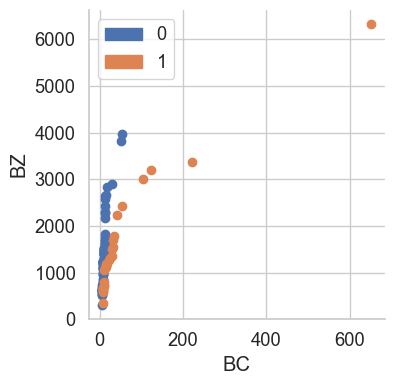

In [117]:
pplot(dt,x = "BC",y="BZ",hue = "Class", kind='qq', height=4, aspect=1)